<a href="https://colab.research.google.com/github/tinayiluo0322/Computer-Engineering-Machine-Learning-and-Deep-Neural-Nets-Projects/blob/main/Construct_Train_Optimize_CNN_Models/resnet_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimizing ResNet20 on CIFAR-10

#### Luopeiwen Yi


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
import os

In [ ]:
# Change this to the absolute path where dataset.py and utils.py are stored
CODE_PATH = "/content/drive/MyDrive/CNN_hw"

# Add this path to sys.path so Python can find it
sys.path.append(CODE_PATH)

# Check if Colab can see the files
print("Files in directory:", os.listdir(CODE_PATH))

Files in directory: ['sample_predictions.csv', 'save_test_predictions.ipynb', '__pycache__', 'tools', 'simplenn-cifar10.ipynb', 'ResNet20_best_validation_model.pth']


# Building ResNet20 From Scratch following Section 4.2 in the paper ["Deep Residual Learning For Image Recognition"](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf)

## Step 1: Model Architecture


## ResNet20 Architecture Details

Total stacked weighted layers: 6n+2 = 20

n = 3

Total shortcut (skip) connections: 3n = 9

### Summary Table
\begin{array}{|c|c|c|c|}
\hline
\textbf{Output Map Size} & \textbf{32 x 32} & \textbf{16 x 16} & \textbf{8 x 8} \\
\hline
\# \text{Layers} & 1 + 2 \times n = 7 & 2 \times n = 6 & 2 \times n = 6 \\
\hline
\# \text{Filters (Channels)} & 16 & 32 & 64 \\
\hline
\# \text{Shortcuts} & 3 & 3 & 3 \\
\hline
\end{array}


### Layer Details

**Input: 32 × 32 Image with 3 Channels**

\begin{array}{|c|c|c|}
\hline
\textbf{Layer Name} & \textbf{Output Size} & \textbf{20 Layers} \\
\hline
\text{Conv1} & 32 \times 32 & 3 \times 3, 16, \text{Stride } 1 \\
\hline
\text{Conv2_x} & 32 \times 32 & [((3 \times 3, 16) \times 2) \text{ per block}] \times 3, \text{Stride } 1 \\
\hline
\text{Conv3_x} & 16 \times 16 & [((3 \times 3, 32) \times 2) \text{ per block}] \times 3 \text{ (Subsampling: Stride 2)} \\
\hline
\text{Conv4_x} & 8 \times 8 & [((3 \times 3, 64) \times 2) \text{ per block} ]\times 3 \text{ (Subsampling: Stride 2)} \\
\hline
\text{Fully Connected} & 1 \times 1 & \text{Global Average Pooling} \\
\hline
\end{array}

**Output: 10 Class Predictions**


### Residual Block Details
Reference: [Dive Into Deep Learning](https://d2l.ai/chapter_convolutional-modern/resnet.html)

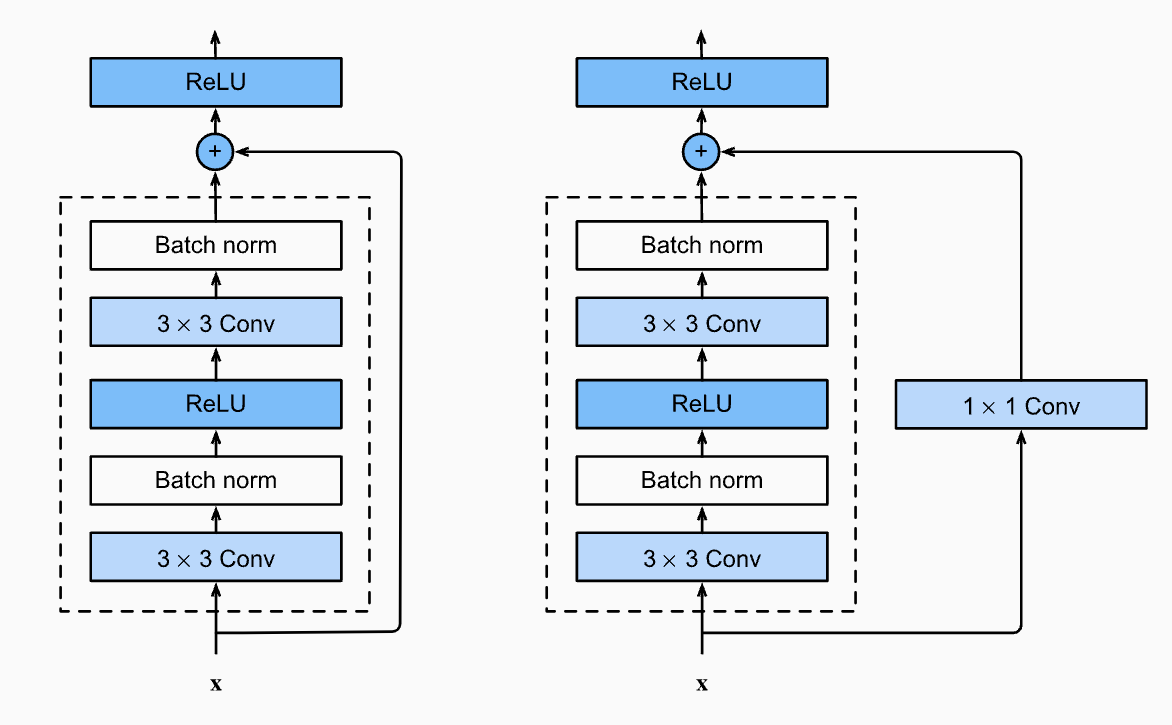




## ResNet20 Architecture Overview

\begin{array}{|c|c|c|c|c|c|c|c|c|c|c|}
\hline
\textbf{Layer Type} & \textbf{Conv Type} & \textbf{Input Size} & \textbf{Output Size} & \textbf{Kernel Size} & \textbf{Stride} & \textbf{Padding} & \textbf{# Filters} & \textbf{Residual Connection} & \textbf{BatchNorm} & \textbf{Activation} \\
\hline
\text{Conv1 (Initial Conv)} & \text{Conv1} & 32\times32\times3 & 32\times32\times16 & 3\times3 & 1 & 1 & 16 & No & Yes & ReLU \\
\hline
\text{Residual Block 1.1 - Conv1} & \text{Conv2_x} & 32\times32\times16 & 32\times32\times16 & 3\times3 & 1 & 1 & 16 & No & Yes & ReLU \\
\text{Residual Block 1.1 - Conv2} & \text{Conv2_x} & 32\times32\times16 & 32\times32\times16 & 3\times3 & 1 & 1 & 16 & Yes (Identity) & Yes & ReLU \\
\hline
\text{Residual Block 1.2 - Conv1} & \text{Conv2_x} & 32\times32\times16 & 32\times32\times16 & 3\times3 & 1 & 1 & 16 & No & Yes & ReLU \\
\text{Residual Block 1.2 - Conv2} & \text{Conv2_x} & 32\times32\times16 & 32\times32\times16 & 3\times3 & 1 & 1 & 16 & Yes (Identity) & Yes & ReLU \\
\hline
\text{Residual Block 1.3 - Conv1} & \text{Conv2_x} & 32\times32\times16 & 32\times32\times16 & 3\times3 & 1 & 1 & 16 & No & Yes & ReLU \\
\text{Residual Block 1.3 - Conv2} & \text{Conv2_x} & 32\times32\times16 & 32\times32\times16 & 3\times3 & 1 & 1 & 16 & Yes (Identity) & Yes & ReLU \\
\hline
\text{Residual Block 2.1 - Conv1} & \text{Conv3_x} & 32\times32\times16 & 16\times16\times32 & 3\times3 & 2 & 1 & 32 & No & Yes & ReLU \\
\text{Residual Block 2.1 - Conv2} & \text{Conv3_x} & 16\times16\times32 & 16\times16\times32 & 3\times3 & 1 & 1 & 32 & Yes (1\times1 Conv) & Yes & ReLU \\
\hline
\text{Residual Block 2.2 - Conv1} & \text{Conv3_x} & 16\times16\times32 & 16\times16\times32 & 3\times3 & 1 & 1 & 32 & No & Yes & ReLU \\
\text{Residual Block 2.2 - Conv2} & \text{Conv3_x} & 16\times16\times32 & 16\times16\times32 & 3\times3 & 1 & 1 & 32 & Yes (Identity) & Yes & ReLU \\
\hline
\text{Residual Block 2.3 - Conv1} & \text{Conv3_x} & 16\times16\times32 & 16\times16\times32 & 3\times3 & 1 & 1 & 32 & No & Yes & ReLU \\
\text{Residual Block 2.3 - Conv2} & \text{Conv3_x} & 16\times16\times32 & 16\times16\times32 & 3\times3 & 1 & 1 & 32 & Yes (Identity) & Yes & ReLU \\
\hline
\text{Residual Block 3.1 - Conv1} & \text{Conv4_x} & 16\times16\times32 & 8\times8\times64 & 3\times3 & 2 & 1 & 64 & No & Yes & ReLU \\
\text{Residual Block 3.1 - Conv2} & \text{Conv4_x} & 8\times8\times64 & 8\times8\times64 & 3\times3 & 1 & 1 & 64 & Yes (1\times1 Conv) & Yes & ReLU \\
\hline
\text{Residual Block 3.2 - Conv1} & \text{Conv4_x} & 8\times8\times64 & 8\times8\times64 & 3\times3 & 1 & 1 & 64 & No & Yes & ReLU \\
\text{Residual Block 3.2 - Conv2} & \text{Conv4_x} & 8\times8\times64 & 8\times8\times64 & 3\times3 & 1 & 1 & 64 & Yes (Identity) & Yes & ReLU \\
\hline
\text{Residual Block 3.3 - Conv1} & \text{Conv4_x} & 8\times8\times64 & 8\times8\times64 & 3\times3 & 1 & 1 & 64 & No & Yes & ReLU \\
\text{Residual Block 3.3 - Conv2} & \text{Conv4_x} & 8\times8\times64 & 8\times8\times64 & 3\times3 & 1 & 1 & 64 & Yes (Identity) & Yes & ReLU \\
\hline
\text{Global Average Pooling} & - & 8\times8\times64 & 1\times1\times64 & 8\times8 & - & - & - & No & No & - \\
\hline
\text{Fully Connected (FC)} & - & 1\times1\times64 & 10 & - & - & - & 10 & No & No & Softmax \\
\hline
\end{array}



## Step 2: Build the model

In [ ]:
# import necessary dependencies
import argparse
import os, sys
import time
import datetime
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

In [ ]:
class ResidualBlock(nn.Module):
    """Residual Block for ResNet-20."""
    def __init__(self, in_channels, out_channels, stride=1, use_1x1conv=False):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection
        self.shortcut = None
        if use_1x1conv:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        # Apply shortcut connection
        if self.shortcut is not None:
            identity = self.shortcut(x)

        out += identity  # Residual connection
        return F.relu(out)

class ResNet20(nn.Module):
    """ResNet-20 model for CIFAR-10."""
    def __init__(self, num_classes=10):
        super(ResNet20, self).__init__()

        self.initial_conv = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.initial_bn = nn.BatchNorm2d(16)

        # Residual Blocks: 3 blocks per stage
        self.layer1 = self._make_layer(16, 16, stride=1, num_blocks=3)
        self.layer2 = self._make_layer(16, 32, stride=2, num_blocks=3)  # Downsample at first block
        self.layer3 = self._make_layer(32, 64, stride=2, num_blocks=3)  # Downsample at first block

        # Global Average Pooling and Fully Connected Layer
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(64, num_classes)

    def _make_layer(self, in_channels, out_channels, stride, num_blocks):
        layers = []

        # First block: only use 1x1 conv shortcut if downsampling (stride=2)
        use_1x1conv = (stride == 2)  # Only use 1x1 conv when changing channels
        layers.append(ResidualBlock(in_channels, out_channels, stride, use_1x1conv))

        # Remaining blocks: No downsampling, no 1x1 conv shortcut
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels, stride=1, use_1x1conv=False))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.initial_bn(self.initial_conv(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

### Sanity Check

In [ ]:
# Define the ResNet20 model
model = ResNet20()

# Create a dummy input tensor with the same shape as CIFAR-10 images (batch_size=1, channels=3, height=32, width=32)
dummy_input = torch.randn(1, 3, 32, 32)  # Shape: (1, 3, 32, 32)

# Pass the dummy input through the model
output = model(dummy_input)

# Check the output shape
print(f"Output shape: {output.shape}")  # Should be (1, 10) since we have 10 classes

# Count total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Output shape: torch.Size([1, 10])
Total number of parameters: 272474


In [ ]:
# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the ResNet20 model and move it to the selected device
model = ResNet20().to(device)

# Create a dummy input tensor and move it to the same device as the model
dummy_input = torch.randn(1, 3, 32, 32).to(device)  # Ensure input is on the same device

# Pass the dummy input through the model
output = model(dummy_input)

# Check the output shape
print(f"Output shape: {output.shape}")  # Should be (1, 10) since we have 10 classes

# Count total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

# Print model summary (Ensure model is on the correct device)
summary(model, (3, 32, 32), device=device.type)  # Specify the device

Using device: cuda
Output shape: torch.Size([1, 10])
Total number of parameters: 272474
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3           [-1, 16, 32, 32]           2,304
       BatchNorm2d-4           [-1, 16, 32, 32]              32
            Conv2d-5           [-1, 16, 32, 32]           2,304
       BatchNorm2d-6           [-1, 16, 32, 32]              32
     ResidualBlock-7           [-1, 16, 32, 32]               0
            Conv2d-8           [-1, 16, 32, 32]           2,304
       BatchNorm2d-9           [-1, 16, 32, 32]              32
           Conv2d-10           [-1, 16, 32, 32]           2,304
      BatchNorm2d-11           [-1, 16, 32, 32]              32
    ResidualBlock-12           [-1, 16, 32, 32]               0
           Conv

## Step 3: Set up preprocessing functions


In [ ]:
import torchvision.transforms as transforms

# Define mean and std for CIFAR-10 dataset normalization
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2023, 0.1994, 0.2010)

# Training Transform (with Augmentation)
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # 4-pixel padding, then 32x32 random crop
    transforms.RandomHorizontalFlip(p=0.5),  # 50% chance of horizontal flip
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize(mean=cifar10_mean, std=cifar10_std)  # Normalize
])

# Validation Transform (No Augmentation, Just Normalization)
transform_val = transforms.Compose([
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize(mean=cifar10_mean, std=cifar10_std)  # Normalize
])

## Step 4: Set up dataset and dataloader


In [ ]:
# Do NOT change these
from tools.dataset import CIFAR10
from torch.utils.data import DataLoader

# A few arguments, do NOT change these
DATA_ROOT = "./data"
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 100

# Construct dataset
train_set = CIFAR10(
    root=DATA_ROOT,
    mode='train',
    download=True,
    transform=transform_train  # Apply training preprocessing
)

val_set = CIFAR10(
    root=DATA_ROOT,
    mode='val',
    download=True,
    transform=transform_val  # Apply validation preprocessing
)

# Construct dataloaders
train_loader = DataLoader(
    train_set,
    batch_size=TRAIN_BATCH_SIZE,  # Use predefined batch size
    shuffle=True,  # Shuffle training data for randomness
    num_workers=4  # Speed up data loading
)

val_loader = DataLoader(
    val_set,
    batch_size=VAL_BATCH_SIZE,  # Use predefined batch size
    shuffle=False,  # No need to shuffle validation data
    num_workers=4
)

# Sanity Check: Print dataset sizes
print(f"Train dataset size: {len(train_set)} images")
print(f"Validation dataset size: {len(val_set)} images")

# Check a single batch
sample_batch, sample_labels = next(iter(train_loader))
print(f"Sample batch shape: {sample_batch.shape}, Labels shape: {sample_labels.shape}")


Using downloaded and verified file: ./data/cifar10_trainval_F22.zip
Extracting ./data/cifar10_trainval_F22.zip to ./data
Files already downloaded and verified
Using downloaded and verified file: ./data/cifar10_trainval_F22.zip
Extracting ./data/cifar10_trainval_F22.zip to ./data
Files already downloaded and verified
Train dataset size: 45000 images
Validation dataset size: 5000 images
Sample batch shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128])


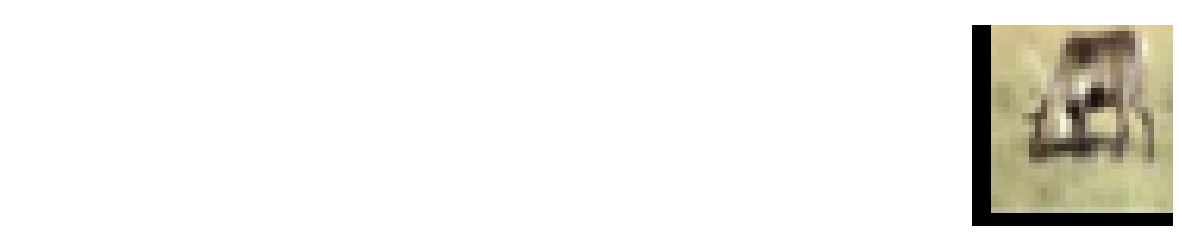

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Load one batch of training data
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Function to unnormalize and display images
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))  # Convert to HWC format
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    img = img * std + mean  # Unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)

# Plot some augmented images
fig, axes = plt.subplots(1, 5, figsize=(15,3))
for i in range(5):
    imshow(images[i])
    axes[i].axis('off')
plt.show()

## Step 5: Set up the loss function and optimizer


In [ ]:
import torch.nn as nn
import torch.optim as optim

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer (SGD with momentum and weight decay)
optimizer = optim.SGD(
    model.parameters(),
    lr=0.1,  # Initial learning rate
    momentum=0.9,
    weight_decay=1e-4  # L2 regularization (weight decay)
)

# Learning rate decay schedule (step-wise decay)
def adjust_learning_rate(optimizer, epoch, iteration):
    """Adjusts learning rate according to ResNet training schedule."""
    # Decay at 32k and 48k, assuming ~64000 total iterations
    if iteration in [32000, 48000]:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1
        print(f"Learning rate decayed to {optimizer.param_groups[0]['lr']} at iteration {iteration}")

# Training parameters
EPOCHS = 200  # Assuming 64000 iterations with batch_size=128 (Approximates 200 epochs)
ITERATIONS_PER_EPOCH = len(train_loader)

# Print optimizer details
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.1
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)


## Step 6: Start the training process.



In [ ]:
def train_model(model, optimizer, filename, epochs=200):
    """ Train the model and save the best checkpoint """

    CHECKPOINT_FOLDER = "/content/drive/MyDrive/CNN_hw"
    best_val_acc = 0

    # Ensure model is on the correct device
    model.to(device)

    # Sanity Check before training
    model.eval()  # Set model to evaluation mode
    initial_loss = 0
    total_examples = 0
    correct_examples = 0

    with torch.no_grad():  # No gradient calculation
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            # Copy inputs and targets to the device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass: compute the output
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, targets)
            initial_loss += loss.item()

            # Compute accuracy before training
            _, predicted = torch.max(outputs, 1)
            correct_examples += (predicted == targets).sum().item()
            total_examples += targets.size(0)

            # Only calculate on a small subset (e.g., 1 batch)
            if batch_idx == 0:
                break

    # Compute initial average loss and accuracy
    initial_loss /= (batch_idx + 1)
    initial_acc = correct_examples / total_examples
    print(f"Initial loss before training: {initial_loss:.4f}, Initial accuracy: {initial_acc:.4f}")

    print(f"==> Training {filename} model")
    print("=" * 50)

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        print(f"Epoch {epoch}:")

        total_examples = 0
        correct_examples = 0
        train_loss = 0

        # Train loop
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            # Calculate current iteration
            current_iteration = epoch * len(train_loader) + batch_idx

            # Call adjust_learning_rate function
            adjust_learning_rate(optimizer, epoch, current_iteration)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Zero gradients & backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_examples += (predicted == targets).sum().item()
            total_examples += targets.size(0)

        avg_loss = train_loss / len(train_loader)
        avg_acc = correct_examples / total_examples
        print(f"Training loss: {avg_loss:.4f}, Training accuracy: {avg_acc:.4f}")

        # Validation loop
        model.eval()
        total_examples = 0
        correct_examples = 0
        val_loss = 0

        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(val_loader):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_examples += (predicted == targets).sum().item()
                total_examples += targets.size(0)

        avg_loss = val_loss / len(val_loader)
        avg_acc = correct_examples / total_examples
        print(f"Validation loss: {avg_loss:.4f}, Validation accuracy: {avg_acc:.4f}")

        # Save best model
        if avg_acc > best_val_acc:
            best_val_acc = avg_acc
            if not os.path.exists(CHECKPOINT_FOLDER):
                os.makedirs(CHECKPOINT_FOLDER)
            print(f"Saving best model for {filename}...")
            torch.save({'state_dict': model.state_dict()}, os.path.join(CHECKPOINT_FOLDER, filename))

        print('')

    print("=" * 50)
    print(f"==> Training finished for {filename}! Best validation accuracy: {best_val_acc:.4f}")

In [ ]:
# Initialize the model
model = ResNet20().to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer (SGD with momentum and weight decay)
optimizer = optim.SGD(
    model.parameters(),
    lr=0.1,  # Initial learning rate
    momentum=0.9,
    weight_decay=1e-4  # L2 regularization (weight decay)
)

# Learning rate decay schedule (step-wise decay)
def adjust_learning_rate(optimizer, epoch, iteration):
    """Adjusts learning rate according to ResNet training schedule."""
    # Decay at 32k and 48k, assuming ~64000 total iterations
    if iteration in [32000, 48000]:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1
        print(f"Learning rate decayed to {optimizer.param_groups[0]['lr']} at iteration {iteration}")

# Train the model and save results
filename = f"ResNet20_best_validation_model.pth"
train_model(model, optimizer, filename)

Initial loss before training: 2.3338, Initial accuracy: 0.1406
==> Training ResNet20_best_validation_model.pth model
Epoch 0:
Training loss: 1.6932, Training accuracy: 0.3630
Validation loss: 1.4708, Validation accuracy: 0.4666
Saving best model for ResNet20_best_validation_model.pth...

Epoch 1:
Training loss: 1.2316, Training accuracy: 0.5549
Validation loss: 1.2066, Validation accuracy: 0.5748
Saving best model for ResNet20_best_validation_model.pth...

Epoch 2:
Training loss: 0.9887, Training accuracy: 0.6484
Validation loss: 1.0395, Validation accuracy: 0.6478
Saving best model for ResNet20_best_validation_model.pth...

Epoch 3:
Training loss: 0.8295, Training accuracy: 0.7069
Validation loss: 0.9839, Validation accuracy: 0.6716
Saving best model for ResNet20_best_validation_model.pth...

Epoch 4:
Training loss: 0.7268, Training accuracy: 0.7462
Validation loss: 0.8318, Validation accuracy: 0.7254
Saving best model for ResNet20_best_validation_model.pth...

Epoch 5:
Training loss:

### Step 7: Generating Test Set Predictions

In [ ]:
# Define paths
DATA_ROOT = "./data"
BATCH_SIZE = 100
CHECKPOINT_PATH = "/content/drive/MyDrive/CNN_hw/ResNet20_best_validation_model.pth"
OUTPUT_DIR = "/content/drive/MyDrive/CNN_hw"

# Ensure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Define test data transform
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load test dataset (DO NOT shuffle)
test_set = CIFAR10(
    root=DATA_ROOT,
    mode='test',
    download=True,
    transform=transform_test
)

test_loader = DataLoader(
    test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=1
)

# Initialize ResNet-20 model and load trained weights
model = ResNet20().to(device)  # Ensure model is on correct device
state_dict = torch.load(CHECKPOINT_PATH, map_location=device)

# Load only the model's state_dict
model.load_state_dict(state_dict["state_dict"])
model.eval()  # Set to evaluation mode

# Generate predictions
results = []
with torch.no_grad():
    for x in test_loader:
        x = x.to(device)  # Ensure test data is on the same device
        results.append(model(x).argmax(1))

# Convert results to numpy array
results = torch.cat(results).cpu().numpy()
assert len(results) == 10000  # Ensure correct length

# Save predictions to CSV
output_file = os.path.join(OUTPUT_DIR, "predictions.csv")

with open(output_file, 'w') as fp:
    fp.write("Id,Label\n")
    for i in range(len(results)):
        fp.write("%d,%d\n" % (i, results[i]))

print(f"Predictions saved to: {output_file}")

28393472it [00:05, 4987438.65it/s]                               


Extracting ./data/cifar10_test_F22.zip to ./data
Files already downloaded and verified


<ipython-input-55-7495e7ae9115>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(CHECKPOINT_PATH, map_location=device)


Predictions saved to: /content/drive/MyDrive/CNN_hw/predictions.csv


In [ ]:
import pandas as pd

# Load the predictions CSV
df = pd.read_csv(output_file)

# Display the first few rows
print("Loaded Predictions:")
print(df.head())

# Check the total number of predictions
print(f"\nTotal Predictions: {len(df)}")

Loaded Predictions:
   Id  Label
0   0      2
1   1      3
2   2      5
3   3      0
4   4      5

Total Predictions: 10000
